In [11]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
env = gym.make("Taxi-v2")
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states, n_actions))

n_states=500, n_actions=6


In [4]:
policy = np.ones((n_states, n_actions))/n_actions

In [7]:
def generate_session(policy,t_max=10**4):
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        a = np.random.choice(n_actions, 1, p=policy[s])[0]
        new_s, r, done, info = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
    return states, actions, total_reward

In [6]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states  = [states_batch[i][j] for i in range(len(states_batch)) for j in range(len(states_batch[i])) if rewards_batch[i] >= reward_threshold]
    elite_actions = [actions_batch[i][j] for i in range(len(actions_batch)) for j in range(len(actions_batch[i])) if rewards_batch[i] >= reward_threshold]
    
    return elite_states,elite_actions

In [8]:
def update_policy(elite_states,elite_actions):
    
    new_policy = np.zeros([n_states,n_actions])
    
    for i in range(len(elite_states)):
        new_policy[elite_states[i]][elite_actions[i]] += 1
        
    new_policy = new_policy / new_policy.sum(axis=1)[:, np.newaxis]
    for i in range(n_states):
        if i not in elite_states:
            new_policy[i] = [1/n_actions]*n_actions
    
    return new_policy

In [9]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards,range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = -256.240, threshold=-41.900


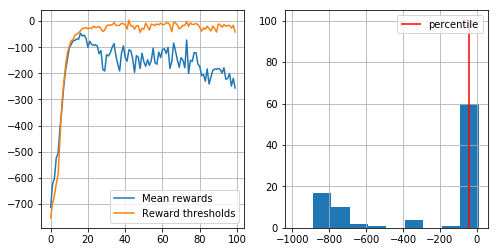

In [12]:
n_sessions = 100  #sample this many sessions
percentile = 45  #take this percent of session with highest rewards
learning_rate = 0.52  #add this thing to all counts for stability

log = []

for i in range(100):
    
    sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    batch_states,batch_actions,batch_rewards = zip(*sessions)

    elite_states, elite_actions = select_elites(batch_states,batch_actions,batch_rewards,percentile)
    
    new_policy = update_policy(elite_states, elite_actions)
    
    policy = learning_rate * new_policy + (1-learning_rate) * policy
    
    show_progress(batch_rewards, log, percentile)